# Biomarker Design using regularized MVA
Author: Carlos Sevilla Salcedo (Updated: 29/05/2018)

On the basis of the parsimonious MVA method proposed in [Aqui habra que poner nuestro link](https://doi.org/10.1016/j.patcog.2017.06.004), this notebook presents an extended and adapted version for its adequate application to neuromarkers design in neuroimage problems. The general diagram developed consists of two steps: 
* 1) A feature selection process composed by a standard version of MVA and a bagging procedure to obtain a subset of selected voxels ($X_{S}$) together to a relevance measure for each selected voxel ($\rho$).
* 2) Biomarker construction based in a regularized version of MVA with the task of reduce the input set of voxels to a reduced subset of biomarkers ($X_{B}$) characterizing each subject under study.

![title](regMVA_scheme.png)

Our revisited method introduces several modifications to the method proposed to adapt it to the neuroimaging scenario. First of all the regularized MVA has been modified to use the sign consistency, which is obtained through the bagged MVA, to design its regularization penalty, having therefore a regularization based in both sign and magnitude consistency. The previous method assumed that the feature selection was enough to use the primal formulation (N > d), nevertheless, we have adapted the MVA to the dual space, as working with neuroimages and a small amount of subjects imply that the selection keeps overcoming the amount of subjects (N << d). The regularized MVA has been modified to consider each class' population and reduce its effect by the inclusion of a balancing matrix. Additionally, we have included a statistical test, designed ad-hoc for the bagged MVA scheme, to be able to automatically select the optimum number of selected features.


## 1. Synthetic Data Generation

In order to test the algorithm, synthetic data has been generated following a gaussian distribution. In our case, we have generated 2 values for each subject, resembling the biomarkers extracted from a neuroimaging.


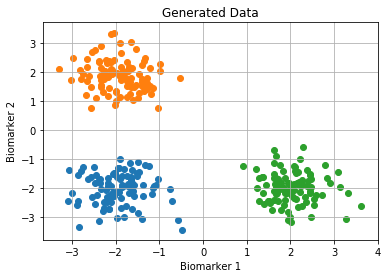

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import math

# Parameters
n_classes = 3        # Amount of classes
R = 2                # Number of extracted biomarkers (R < n_classes)
sigma = 0.5          # Standard deviation
mean = 2             # Mean value
N_cl = 100           # Samples per class (Balanced version)
N = N_cl*n_classes   # Total samples

if R > n_classes-1:
    print 'Maximum number of new projections fixed to ' + str(n_classes-1)
    R = n_classes-1
            
# Biomarker generation

mu = np.zeros((n_classes,R))
for i in np.arange(n_classes):
    num = bin(i)[2:]
    for j in np.arange(R):
        if j < (R-len(num)):
            mu[i,j] = -1
        else:
            mu[i,j] = (int(str(num)[j-(R-len(num))])*2)-1
    if len(num) > R:
        mu[i,:] = mu[i,:]*(math.ceil(len(num)/R)+1)

mu = np.dot(mean,mu)
bio = np.zeros((N_cl*n_classes,R))
Y = np.zeros((N_cl*n_classes))

for i in np.arange(n_classes):
    for j in np.arange(R):
        bio[i*N_cl:(i+1)*N_cl,j] = np.random.normal(mu[i,j], sigma, N_cl)
        Y[i*N_cl:(i+1)*N_cl] = (i*np.ones((N_cl,1))).flatten()
Y = Y.astype(int)

def plot_biomarkers(bio,Y,txt):
# -------------------------------------------------------------------- #
# This function plots the biomarkers of up to 4 classes                #
# -------------------------------------------------------------------- #
# Input:                                                               #
# - bio: NxR matrix containing the R defined biomarkers of N subjects  #
# - Y:   target matrix containing the labels of the subjects           #
#--------------------------------------------------------------------- #
    
    mx = np.max(bio)
    mn = np.min(bio)
    if R == 3:
        from mpl_toolkits.mplot3d import Axes3D
        fig = plt.figure()
        ax = fig.add_subplot(111, projection='3d')
        for i in range(n_classes):
            idx = np.where(Y == i)
            ax.scatter(bio[idx,0], bio[idx,1],bio[idx,2], cmap=plt.cm.Paired )      
            ax.set_xlabel('Biomarker 1')
            ax.set_ylabel('Biomarker 2')
            ax.set_zlabel('Biomarker 3')
            plt.grid()
        ax.set_xlim([mn,mx])
        ax.set_ylim([mn,mx])
        ax.set_zlim([mn,mx])
        plt.title(txt)
        plt.show() 
    elif R == 2:
        for i in range(n_classes):
            idx = np.where(Y == i)
            plt.scatter(bio[idx,0], bio[idx,1], cmap=plt.cm.Paired )      
            plt.xlabel('Biomarker 1')
            plt.ylabel('Biomarker 2')
        plt.grid()
        plt.title(txt)
        plt.show() 
    elif R == 1:
        for i in range(n_classes):
            idx = np.where(Y == i)
            plt.scatter(bio[idx,0], np.zeros((np.shape(bio[idx,0]))), cmap=plt.cm.Paired )      
            plt.xlabel('Biomarker 1')
        plt.grid()
        plt.title(txt)
        plt.show()
if R<4:
    import matplotlib.pyplot as plt
    plot_biomarkers(bio,Y,'Generated Data')

For the purpose of adding more noise to the generated data, a random projection matrix $U_{pro}$ has been defined to move these 2 generated biomarkers to a space of higher dimension, having that the new data dimension is $N \times dim_{good}$. Random noise is added to these features in order to check the performance of the feature selection of dimension $dim_{noise}$. This way the generated matrix $X$ is of dimensions $N \times dim$, where $dim = dim_{good}+dim_{noise}$.

In [2]:
# Parameters
dim_good = 600             # Dimension of the projection matrix
dim_noise = 2900           # Dimension of the added random noise
dim = dim_good + dim_noise   # Data dimension

set_classes = np.unique(Y)

U_pro = np.random.uniform(-1.0, 1.0, (dim_good,R))  # Random projection matrix
X_pro = np.dot(bio,U_pro.T)

X = np.hstack((X_pro, np.random.rand(N,dim_noise)))
print 'The generated data are of size ' +str(X.shape[0])+' x '+str(X.shape[1])
idx = np.arange(dim)
idx_noise = idx >= dim_good  # Index of noisy features
idx_good = idx < dim_good    # Index of useful features

The generated data are of size 300 x 3500


## 2. Bagged MVA

Once the database is generated, it is splitted into a training and a test set and scaled.

The train dataset is the one used to generate the model which is ultimately checked by the test dataset.

In [3]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from IPython.display import Latex

X_tr, X_tst, Y_tr, Y_tst = train_test_split(X, Y, test_size=0.3)

scaler = StandardScaler()
X_tr = scaler.fit_transform(X_tr)
X_tst = scaler.transform(X_tst)

Following, a feature selection method is implemented with a MVA bagging. This procedure genrates P projection matrices *U* and stores the sign consistency each voxel has as well as the magnitude of the eigenvectors. Through the repetitions of the calculation of the projection matrices different randomly sampled data are used, obtaining a measure of the relevance of each voxel independently of the subject evalued.

In [4]:
reg1_opt = 1e0
P_it = 10000
M_rate = 0.5
method = 'CCA'

from sklearn.preprocessing import label_binarize
import sys
sys.path.append('lib') #Import MVA function
from mva import mva

N,dim = X_tr.shape
set_classes = np.unique(Y)
n_classes = len(set_classes)

Y_tr_b = label_binarize(Y_tr, classes = set_classes, neg_label = -1)

sub_class = long(round(N*M_rate/n_classes))

print 'Amount of subjects: ' +str(N)
print 'Samples taken per class: ' +str(sub_class)

Abag =  1     #Si está a 1 es Fast Si está a 0 Slow

#Upc_sum = np.zeros((n_classes,dim,n_classes))
#Up_bin = np.zeros((dim,n_classes))
#Upc_bin_sum = np.zeros((n_classes,dim,n_classes))

Upc_sum = np.zeros((n_classes,dim,R))
Up_bin = np.zeros((dim,R))
Upc_bin_sum = np.zeros((n_classes,dim,R))

CCA = mva(method, R)
if Abag:
    CCA.fit(X_tr, Y_tr_b, reg = reg1_opt)
    A = CCA._mva__dual_weights
    
for p in np.arange(P_it):
    idx_sub = []
    subj = np.arange(N)
    for cl in set_classes:
        idx_cl = subj[Y_tr == cl]
        np.random.shuffle(idx_cl)
        idx_cl = idx_cl[:sub_class]
        #idx_sub = np.hstack((idx_sub,idx_cl)).astype(int)
        idx_sub = idx_cl
        
        Xp = X_tr[idx_sub,:]

        if Abag:
            Ap = A[idx_sub,:]
            Up = np.dot(Xp.T,Ap)
            Up_tot = Up
            #Up_tot = np.dot(Up,CCA._mva__y_weights.T)
        else:
            Yp = Y_tr_b[idx_sub,:]
            CCA.fit(Xp, Yp, reg = reg1_opt)
            Up = CCA._mva__x_weights
            Up_tot = Up
            #Up_tot = np.dot(Up,CCA._mva__y_weights.T)
        Upc_sum[cl,:,:] = Upc_sum[cl,:,:] + Up_tot
        Up_bin[Up_tot >= 0] = 1
        Up_bin[Up_tot < 0] = 0
        
        Upc_bin_sum[cl,:,:] = Upc_bin_sum[cl,:,:] + Up_bin 
        
Psi = Upc_bin_sum/P_it
Nor = 2*Psi - 1
B = abs(Nor)
b = np.sum(B,axis=2)/R
rho = 2*np.linalg.norm(Upc_sum/float(P_it),axis=2)

Amount of subjects: 210
Samples taken per class: 35


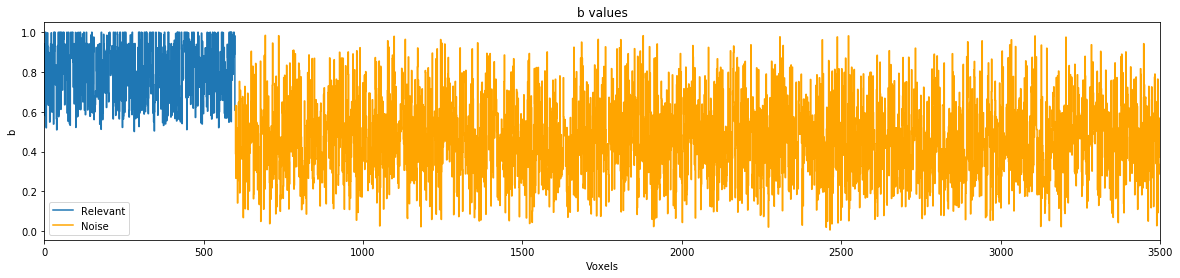

In [5]:
cl = 2      #Plo

plt.figure(figsize=(20, 4))
plt.step(idx[idx_good],b[cl,idx_good], label='Relevant')
#plt.step(idx[cl*200:200*(cl+1)],b[cl,cl*200:200*(cl+1)],'green' , label='Class Relevant')
plt.step(idx[idx_noise],b[cl,idx_noise],'orange', label='Noise')

plt.xlabel('Voxels')
plt.ylabel('b')
plt.xlim(0,dim)
plt.title('b values')
plt.legend()

This vector b contains the sign consistency over the bagging iterations and therefore is capablo of determining which voxels are relevant for the classification and which aren't.

## 3. Hypothesis Test

Once the bagging procedure is completed, a hypothesis test is applyed to the sign consistency vector in order to determine themost relevant ones.

In [6]:
# Parameters
alp = 0.01     # Significancy
p_th = 1-alp   # Threshold

from scipy.stats import norm
def computeZTest(p_psi, gamma, R, p0=0):
# -------------------------------------------------------------------- #
# Hypothesis test containing variance correction.                      #
# -------------------------------------------------------------------- #
# Input:                                                               #
# - psi: dim x R vector containing the sign consistency                #
# - gamma: Subsampling rate                                            #
# - R: amount of extracted features (In our case R=2 biomarkers)       #
# -------------------------------------------------------------------- #
# Output:                                                              #
# - t: dim x 1 vector containing the statistic of each feature         # 
# - t_th:        # 
#--------------------------------------------------------------------- #
    
    t_th = np.sqrt(2)/R*norm.ppf((p_th**(1.0/R)+1)/2)
    
    with np.errstate(divide='ignore'):
        t = (1./R*(np.sum(np.abs(2*p_psi-1),axis=1)))/(4*gamma/(1-gamma)*np.sum(p_psi*(1-p_psi),axis=1))
    
    return t, t_th

t = np.zeros((n_classes,dim))
for cl in set_classes:
    #Number of selected features, determined by the hypothesis test statictic
    tc, t_th = computeZTest(Psi[cl,:,:],M_rate,R)    
    t[cl,:] = tc


In order to evaluate the performance of the feature selector, we have generated some figures to understand its performance based on the selection of the features that are not noise and, therefore, have been directly generated by the random matrix $U_{pro}$.


Threshold t: 1.98430094955
508 elements have been selected, of which 440 are correctly selected out of 600
608 elements have been selected, of which 434 are correctly selected out of 600
337 elements have been selected, of which 258 are correctly selected out of 600
(910L,)


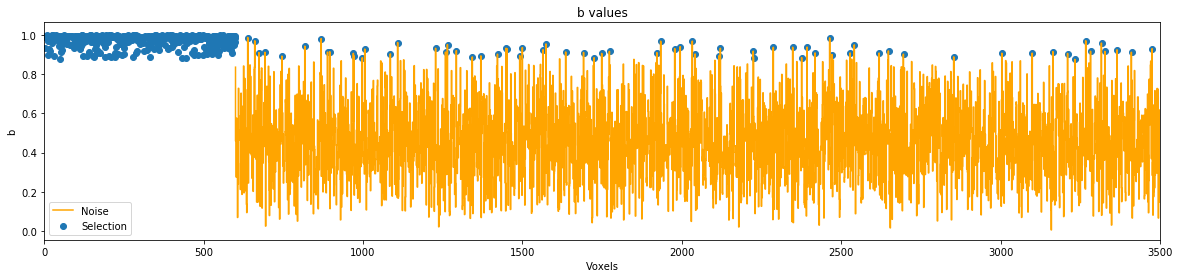

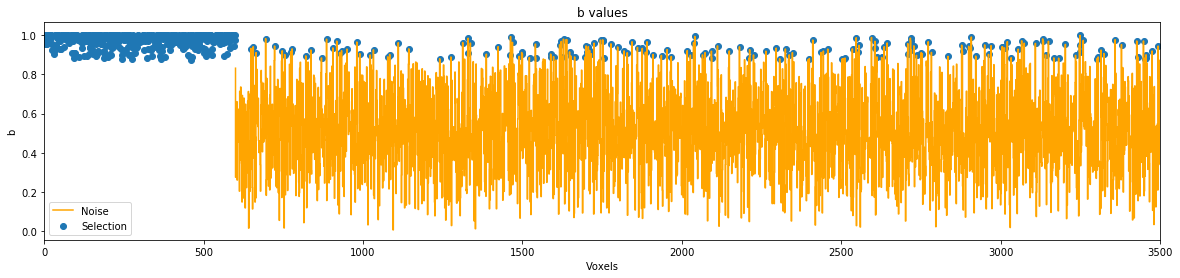

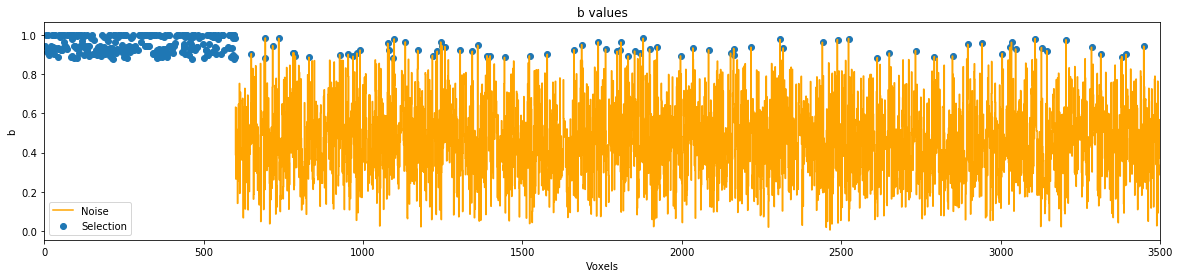

In [7]:
S = np.zeros((n_classes,dim))
S_tot = []

print 'Threshold t: ' + str(t_th)

for cl in set_classes:
    S[cl,:] = np.arange(dim)
    S_tot = np.hstack((S_tot,S[cl,t[cl,:]>t_th]))
    idx = np.arange(dim)
    idx_par_est = S[cl,t[cl,:]>t_th].astype(int)
    idx_par = idx[idx_good]
    shared_num = []
    for number in idx_par_est:
        if number in idx_par:
            shared_num.append(number)
    print str(len(idx_par_est))+' elements have been selected, of which '+str(len(shared_num))+' are correctly selected out of '+str(dim_good)
    
    plt.figure(figsize=(20, 4))
    #plt.step(idx[cl * rel:(cl+1)*rel],b[cl,cl * rel:(cl+1)*rel],'green' , label='Class Relevant')
    plt.scatter(idx[idx_par_est],b[cl,idx_par_est], label='Selection')
    plt.step(idx[idx_noise],b[cl,idx_noise],'orange', label='Noise')

    plt.xlabel('Voxels')
    plt.ylabel('b')
    plt.xlim(0,dim)
    plt.title('b values')
    plt.legend(loc = 3)

S_sel, count = np.unique(S_tot, return_counts = True)
print S_sel.shape
S = S_sel.astype(int)

X_tr_S = X_tr[:,S]
X_tst_S = X_tst[:,S]

910 elements have been selected, of which 600 are correctly selected out of 600


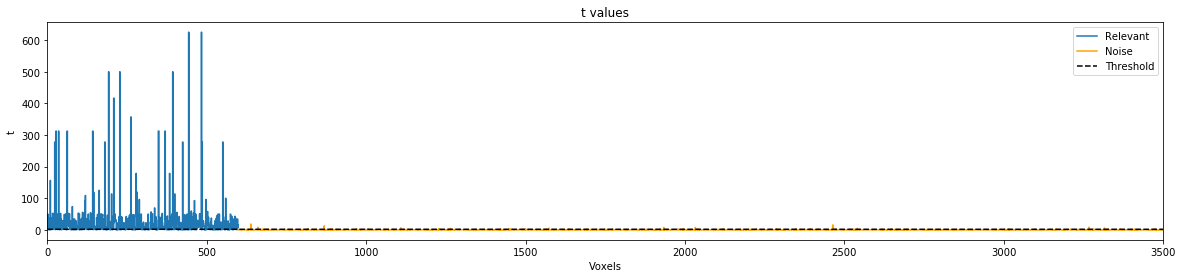

In [9]:
cl = 0

plt.figure(figsize=(20, 4))
#t [t==np.inf] = 10000
plt.step(idx[idx_good],t[cl,idx_good], label='Relevant')
plt.step(idx[idx_noise],t[cl,idx_noise],'orange', label='Noise')
horiz_line_data = np.array([t_th for i in xrange(dim)])
plt.plot(idx, horiz_line_data, 'k--', label='Threshold') 

plt.xlabel('Voxels')
plt.ylabel('t')
plt.xlim(0,dim)
plt.title('t values')
plt.legend()

idx = np.arange(dim)
idx_par_est = S
idx_par = idx[idx_good]

shared_num = []
for number in idx_par_est:
    if number in idx_par:
        shared_num.append(number)
print str(len(S))+' elements have been selected, of which '+str(len(shared_num))+' are correctly selected out of '+str(dim_good)

At the same time, the bagging procedure provides a measure of the relevance of each voxel considering the magnitude of each eigenvector.

The noisy voxels, which have a considerably lower value of relevance, are subsequently used as a parameter for the regularized MVA.

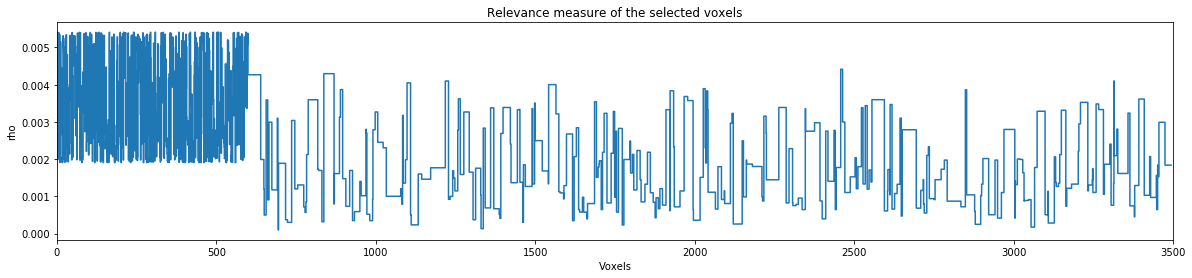

In [10]:
cl = 0

plt.figure(figsize=(20, 4))
plt.step(idx[S],rho[cl,S])
plt.xlabel('Voxels')
plt.ylabel('rho')
plt.xlim(0,dim)
plt.title('Relevance measure of the selected voxels')

## 4. Regularized MVA

Once the bagged MVA-based feature selection is applied, we obtain a parsimonious pattern, defined by a set of selected features, together with their relevance. Here, we will combine both informations to train a parsimonious regularized MVA which will finally provide the desired biomarkers.

This step focuses on generating the biomarkers by penalising the selected voxels that are less relevant. This penalization is obtained as the inverse of the relevance calculated whithin the bagging of MVA. At the same time, the method considers if you want to balance the data by their classes.

In [ ]:
#Parameters
reg2 = 75      # Regularization parameter

def Biomarker_Design(X_tr_S, Y_tr, X_tst_S, Y_tst, reg2, R, M_rate, b, omega, bal):
# -------------------------------------------------------------------- #
# This function applies an MVA to the input data using the provided    #
# consistency vectors to regularize the projetcion. This way R         #
# features are determined.                                             #
# -------------------------------------------------------------------- #
# Input:                                                               #
# - X_tr: Nxdim matrix containing the training data samples            #
# - Y_tr: Nx1 vector containing the training data labels               #
# - X_tst: Nxdim matrix containing the test data samples               #
# - Y_tst: Nx1 vector containing the test data labels                  #
# - reg2: projection regularization hyperparameter                     #
# - R: amount of extracted features (In our case R=2 biomarkers)       #
# - M_rate: Subsampling rate                                           #
# - b: dim x 1 vector containing the sign consistency                  #
# - omega: dim x 1 vector containing the magnitude consistency         #
# - bal: flag that indicates whether balancing wants to be applied     #
# or not                                                               #
# -------------------------------------------------------------------- #
# Output:                                                              #
# - X_tr_B: N x R matrix containing the projection of the training     #
# data samples                                                         #
# - X_tst_B: N x R matrix containing the projection of the test data   # 
# samples                                                              #
# - S: Selected features determined by the statistc applied to the     #
# sign consistency vector.                                             #
#--------------------------------------------------------------------- #

    # Binarize the labels for supervised feature extraction methods
    set_classes = np.unique(Y_tr)
    Y_tr_b = label_binarize(Y_tr, classes=set_classes)
    Y_tst_b = label_binarize(Y_tst, classes=set_classes)
        
    Y_tr_b[Y_tr_b == 0] = -1
    Y_tst_b[Y_tst_b == 0] = -1
        
    N, dim = X_tr.shape
    N, n_classes = Y_tr_b.shape
    
    if bal:
        theta1 = np.ones((N,1))
        for clas in np.unique(Y_tr):
            theta1[Y_tr == int(clas)] = float(N)/float(np.count_nonzero(Y_tr == int(clas)))
        theta_s = np.diag(theta1.flatten())
    
    regCCA = mva (method, R)
    omg = np.divide(omega,b)
    #Omg_s =np.diag(omg[S])   
    Omg_s = np.diag(omg) 
    regCCA.fit(X_tr_S, Y_tr_b, reg = reg2, omg = Omg_s)

    X_tr_B = regCCA.transform(X_tr_S)
    X_tst_B = regCCA.transform(X_tst_S)
    
    return X_tr_B, X_tst_B

rho2 = np.max(rho[:,S],axis = 0)
#rho2 = np.ones((dim,1)).flatten()
b2 = np.max(b[:,S],axis = 0)
omega = 1./rho2 #Contains the regularization term based on the magnitude of the eigenvectors

X_tr_B, X_tst_B = Biomarker_Design(X_tr_S, Y_tr, X_tst_S, Y_tst, reg2, R, M_rate, b2, omega, 0)

if R<4:
    plot_biomarkers(X_tr_B,Y_tr,'Training Set')
    plot_biomarkers(X_tst_B,Y_tst,'Test Set')